##### Necessary Imports

from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon

In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

##### Generate training data

In [3]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

X = nd.random_normal(shape=(num_examples, num_inputs))
noise = 0.01 * nd.random_normal(shape=(num_examples,))
y = real_fn(X) + noise

###### Setup Gluon Data Loader

In [4]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                      batch_size=batch_size, shuffle=True)

##### Simple neural network with 2 layers. Layer 1 : Input Layer 2 : 1 single fully connected neuron 

In [29]:
net = gluon.nn.Dense(1, in_units=2)

In [9]:
print(net.weight)
print(net.bias)

Parameter dense1_weight (shape=(1, 2), dtype=<class 'numpy.float32'>)
Parameter dense1_bias (shape=(1,), dtype=<class 'numpy.float32'>)


##### Init weights and bias for this network

In [31]:
net.collect_params().initialize(mx.init.Normal(sigma=1), ctx=model_ctx)

##### Define loss function

In [32]:
square_loss = gluon.loss.L2Loss()

##### Defining SDG trainer

In [34]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0001})

##### Run NN for some epochs

In [35]:
epochs = 10
loss_sequence = []
num_batches = num_examples / batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.mean(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cumulative_loss / num_examples))
    loss_sequence.append(cumulative_loss)

Epoch 0, loss: 2.78071985246
Epoch 1, loss: 1.6644117082
Epoch 2, loss: 0.996283936483
Epoch 3, loss: 0.596390408181
Epoch 4, loss: 0.357025376154
Epoch 5, loss: 0.213744507429
Epoch 6, loss: 0.127975151457
Epoch 7, loss: 0.0766283292859
Epoch 8, loss: 0.04588762613
Epoch 9, loss: 0.0274823570065


##### Learning curve plot

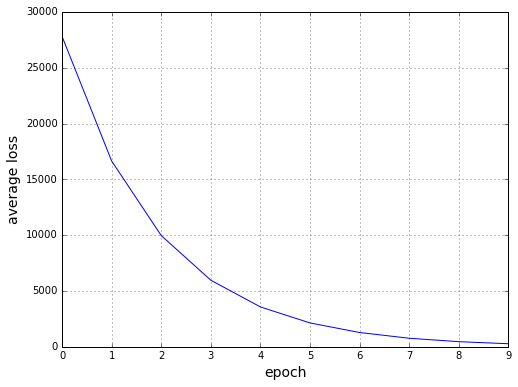

In [37]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6))
plt.plot(loss_sequence)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch',fontsize=14)
plt.ylabel('average loss',fontsize=14)